### State of the Arts - Sin Experiment
---
### New Models Drawn

$\bullet$ Applying state of the Arts methodology to pruning of an LSTM NN network. 

$\bullet$ Conditions are that the original network that was created in the very first instance for own methodology testing will be prunned. All esle conditions are maintained the same. The SOTA that is used, is referenced from the work of https://arxiv.org/pdf/1710.01878.pdf

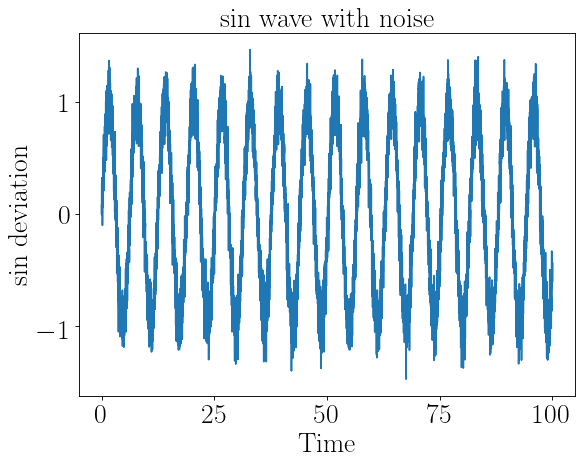

In [1]:
#First we do implementation function by function to tune everything
#First Create some data to work with

#We need several inports and condition pre-sets first
%matplotlib inline
import torch
import numpy as np
seed_value = 42
torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed_value)

def wave(instances,
         duration,
         add_err,
         wave_type="cos",
         show=True,
         save_fig=False):
    """
                                         Description:
    ------------------------------------------------------------------------------------------
    This function will create data for a sin or a cos wave. Dummy data to experiment with.
    ------------------------------------------------------------------------------------------

                                      Input Parameters:
    ------------------------------------------------------------------------------------------
    > instances = amount of data points generated;
    > duration  = how long is the x-axis;
    > add_err   = addition of random noise;
    > wave_type = "cos" or "sin" waves. DEFAULT: "cos";
    > show      = show the graph of how the data looks. DEFAULT: True;
    > save_fig  = save the figure or not. DEFAULT: False;
    ------------------------------------------------------------------------------------------

                                          Outputs:
    ------------------------------------------------------------------------------------------
    > y = data points generated
    ------------------------------------------------------------------------------------------"""

    # load packages:
    import numpy as np
    import matplotlib.pyplot as plt

    # Create data for the x-axis and noise
    x = np.linspace(0, duration, instances)
    noise = np.random.normal(0, add_err, len(x))

    # Decide if sin or cos waves are built and create those data points a y-axis
    if wave_type == "cos":
        y = np.cos(x) + noise
    elif wave_type == "sin":
        y = np.sin(x) + noise
    else:
        print("You indicated a type '{}' of a wave. Currently support only exists for 'cos' or 'sin'.".format \
                  (wave_type))
        return

    # Decide if we want to show the graph for how the data was generated
    if show == True:
        f = plt.figure(figsize=(8, 6), dpi=80)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        #Adjustments to the font
        MEDIUM_SIZE = 25
        plt.rc('font', size = MEDIUM_SIZE)      
        plt.rc('axes', titlesize = MEDIUM_SIZE)     
        plt.rc('axes', labelsize = MEDIUM_SIZE)    
        plt.rc('xtick', labelsize = MEDIUM_SIZE)    
        plt.rc('ytick', labelsize = MEDIUM_SIZE)    
        plt.rc('legend', fontsize = MEDIUM_SIZE)    
        plt.rc('figure', titlesize = MEDIUM_SIZE)
        
        plt.plot(x, y)
        plt.xlabel("Time")
        plt.ylabel(wave_type + " deviation")
        plt.title(wave_type + " wave with noise")
        plt.show()

    # Decide if the graph should be saved of the data visualized
    if save_fig == True:
        f = plt.figure(figsize=(8, 6), dpi=80)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        #Adjustments to the font
        MEDIUM_SIZE = 25
        plt.rc('font', size = MEDIUM_SIZE)      
        plt.rc('axes', titlesize = MEDIUM_SIZE)     
        plt.rc('axes', labelsize = MEDIUM_SIZE)    
        plt.rc('xtick', labelsize = MEDIUM_SIZE)    
        plt.rc('ytick', labelsize = MEDIUM_SIZE)    
        plt.rc('legend', fontsize = MEDIUM_SIZE)    
        plt.rc('figure', titlesize = MEDIUM_SIZE)
        
        plt.plot(x, y)
        plt.xlabel("Time")
        plt.ylabel(wave_type + " deviation")
        plt.title(wave_type + " wave with noise")
        f.savefig("Wave_generated.pdf", bbox_inches='tight')
        plt.close(f)

    # Return data for future use
    return y

full_data = wave(instances = 7000,
                 duration = 100,
                 add_err = 0.15,
                 wave_type = "sin",
                 show = True,
                 save_fig = False)

In [2]:
#Initiate gpu and cuda
def gpu_activation(signal="cpu",
                   confirm=False):
    """
                                        Description:
    ----------------------------------------------------------------------------------------
    Define which component will be handeling data manipulation in the network
    ----------------------------------------------------------------------------------------

                                      Input Parameters:
    ----------------------------------------------------------------------------------------
    > signal  = Either 'gpu' or 'cpu'. DEFAULT: 'cpu';
    > confirm = Show which device was set-up. DEFAULT: False;
    ----------------------------------------------------------------------------------------

                                         Outputs:
    ----------------------------------------------------------------------------------------
    > device = specific device that has properties of either running 'cpu' or 'gpu';
    ----------------------------------------------------------------------------------------
    """
    # Import packages
    import torch

    # Prepare the device
    if signal == "cpu":
        device = torch.device("cpu")
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if confirm == True:
        print("Currently [{}] was set up for usage".format(device))

    # Return the pre-sets for the device
    return device

device = gpu_activation("gpu", 
                        confirm = True)

Currently [cuda] was set up for usage


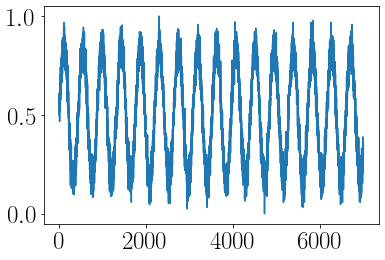

In [3]:
#Scale our data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
full_data = scaler.fit_transform(full_data.reshape(-1, 1))
full_data = full_data.reshape(1, -1)[0]

#EXTRA: FOR VERIFICATION NO MORE
import matplotlib.pyplot as plt
plt.plot(full_data)
plt.show()

--------------------------------LOG-----------------------------------
	Training data has the following shape: 		(5560, 20)
	Training targets have the following shape: 	(5560, 20)

	Testing data has the following shape: 		(70, 20)
	Testing targets have the following shape: 	(70, 20)
----------------------------------------------------------------------


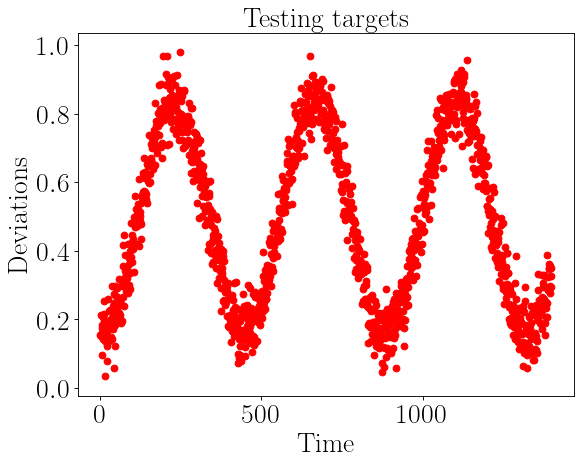

In [4]:
#Split the data

def window_slider(data,
                  initial_data,
                  pred_data,
                  splitter=2 / 3,
                  prepare_log=False,
                  integrity=False,
                  save_fig=False):
    """
                                                 Description:
    ----------------------------------------------------------------------------------------------------------------
    This function will prepare the data for training and testing.

    The training data will be created with a sliding window itterator increases by 1 unit over time.
    The sliding window for the testing data will be increasing by the amount of units we need to predict.

    NB. as work is done on univariate dataset - it will be checked whether the data given has only one dimension.
    Data will be seperated into the correct format when it's feed into the LSTM network right at that moment. Current
    actions will only prepare everything in arrays and sequences, for convenience of data processing.
    ----------------------------------------------------------------------------------------------------------------

                                                Input Parameters:
    ----------------------------------------------------------------------------------------------------------------
    > data         = dataset which will be used for being seperated;
    > initial_data = amount of data points that are used for making predictions;
    > pred_data    = amount of data points to predict into the future;
    > splitter     = how much information should be dedicated to the training. DEFAULT: 2/3;
    > prepare_log  = will give a short summary on what was prepared with the data and print it. DEFAULT: False;
    > integrity    = indicate whether you want the graph for the training outputs to be visualized. DEFAULT: False;
    > save_fig     = Save the figure of what data pattern needs to be predicted. DEFAULT: False;
    ----------------------------------------------------------------------------------------------------------------

                                                      Outputs:
    ----------------------------------------------------------------------------------------------------------------
    > x_training     = training data, data;
    > y_training     = training data, labels/target values;

    > x_testing      = testing data, data;
    > y_testing      = testing data, labels/target values;
    ----------------------------------------------------------------------------------------------------------------
    """

    # Import packages
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    # Transform data if it's not in a numpy format already
    data = np.array(data)

    if data.ndim != 1:
        print("Your data seems to be of {} dimensions, when it should be only 1.".format(data.ndim))
        return

    # Prepare information that will be used for the data that we will train info on and its' targets
    data_holder = []
    targets_holder = []

    # Further build the data accumulator
    idx_start = 0  # starting point
    idx_finish = (initial_data + pred_data)  # finishing position (this should not exceed our data)
    while idx_finish <= len(data):
        data_holder.append(data[idx_start: idx_start + initial_data])
        targets_holder.append(data[idx_start + initial_data: idx_finish])

        idx_start += pred_data
        idx_finish += pred_data

    data_holder = np.array(data_holder)
    targets_holder = np.array(targets_holder)

    # Split the data for testing
    for_training = int(data_holder.shape[0] * splitter)

    x_testing = data_holder[for_training:]
    y_testing = targets_holder[for_training:]

    # NOW WE CHANGE THE SLIDING WINDOW
    # THIS WILL GIVE US MORE DATA TO TRAIN ON AND HOPEFULLY IN A MORE EFFICIENT MANNER
    # THIS DATA WILL BE FOR THE TRAINING AND WE NEED TO PARSE IT FIRST

    data_holder = []
    targets_holder = []

    for amount in range(0, int(len(data) * splitter) - initial_data - pred_data):
        data_holder.append(data[amount: initial_data + amount])
        targets_holder.append(data[amount + initial_data: amount + pred_data + initial_data])

    data_holder = np.array(data_holder)
    targets_holder = np.array(targets_holder)

    x_training = data_holder
    y_training = targets_holder

    if prepare_log == True:
        print("--------------------------------LOG-----------------------------------")
        print("\tTraining data has the following shape: \t\t{}".format(x_training.shape))
        print("\tTraining targets have the following shape: \t{}".format(y_training.shape))
        print()
        print("\tTesting data has the following shape: \t\t{}".format(x_testing.shape))
        print("\tTesting targets have the following shape: \t{}".format(y_testing.shape))
        #         print()
        #         print("First 3 instances of the training data and targets:")
        #         print(x_training[0])
        #         print(x_training[1])
        #         print(x_training[2])
        #         print("----------------------------------------------")
        #         print(y_training[0])
        #         print(y_training[1])
        #         print(y_training[2])
        #         print()
        #         print("First 3 instances of the testing data and targets:")
        #         print(x_testing[0])
        #         print(x_testing[1])
        #         print(x_testing[2])
        #         print("----------------------------------------------")
        #         print(y_testing[0])
        #         print(y_testing[1])
        #         print(y_testing[2])
        print("----------------------------------------------------------------------")

    # Transform information into tensors
    x_training = torch.tensor(x_training)
    y_training = torch.tensor(y_training)

    x_testing = torch.tensor(x_testing)
    y_testing = torch.tensor(y_testing)

    if integrity == True:
        f = plt.figure(figsize=(8, 6), dpi=80)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        #Adjustments to the font
        MEDIUM_SIZE = 25
        plt.rc('font', size = MEDIUM_SIZE)      
        plt.rc('axes', titlesize = MEDIUM_SIZE)     
        plt.rc('axes', labelsize = MEDIUM_SIZE)    
        plt.rc('xtick', labelsize = MEDIUM_SIZE)    
        plt.rc('ytick', labelsize = MEDIUM_SIZE)    
        plt.rc('legend', fontsize = MEDIUM_SIZE)    
        plt.rc('figure', titlesize = MEDIUM_SIZE)

        # Visualize data for the testing set targets
        collector = []
        for value in range(y_testing.shape[0]):
            for number in y_testing[value].numpy():
                collector.append(number)

        plt.scatter(y=collector, x=range(0, len(collector)), c="red")
        plt.xlabel("Time", fontsize=MEDIUM_SIZE)
        plt.ylabel("Deviations", fontsize=MEDIUM_SIZE)
        plt.title("Testing targets", fontsize=MEDIUM_SIZE)
        plt.show()

    if save_fig == True:
        f = plt.figure(figsize=(8, 6), dpi=80)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        #Adjustments to the font
        MEDIUM_SIZE = 25
        plt.rc('font', size = MEDIUM_SIZE)      
        plt.rc('axes', titlesize = MEDIUM_SIZE)     
        plt.rc('axes', labelsize = MEDIUM_SIZE)    
        plt.rc('xtick', labelsize = MEDIUM_SIZE)    
        plt.rc('ytick', labelsize = MEDIUM_SIZE)    
        plt.rc('legend', fontsize = MEDIUM_SIZE)    
        plt.rc('figure', titlesize = MEDIUM_SIZE)

        collector = []
        for value in range(y_testing.shape[0]):
            for number in y_testing[value].numpy():
                collector.append(number)

        plt.scatter(y=collector, x=range(0, len(collector)), c="red")
        plt.xlabel("Time", fontsize=MEDIUM_SIZE)
        plt.ylabel("Deviations", fontsize=MEDIUM_SIZE)
        plt.title("Testing targets", fontsize=MEDIUM_SIZE)
        f.savefig("Testing targets.pdf", bbox_inches='tight')
        plt.close(f)

    return x_training, y_training, x_testing, y_testing

x_training, y_training, x_testing, y_testing = window_slider(data = full_data,
                                                             initial_data = 20,
                                                             pred_data = 20,
                                                             splitter = 8/10,
                                                             prepare_log = True,
                                                             integrity = True,
                                                             save_fig = False)

In [5]:
def loaders(x_training,
            y_training,
            x_testing,
            y_testing,
            BATCH=10,
            SHUFFLE_TRAIN=True,
            SHUFFLE_TEST=False,
            verify=False):
    """
                                                    Description:
    -------------------------------------------------------------------------------------------------------------------
    This will prepare the data loaders, so data is loaded in batches and not all together.
    -------------------------------------------------------------------------------------------------------------------

                                                  Input Parameters:
    -------------------------------------------------------------------------------------------------------------------
    > x_training    = the tensor with the training data;
    > y_training    = the tensor with the training labels;
    > x_testing     = the tensor with the testing data;
    > y_testing     = the tensor with the testing labels;
    > BATCH         = the size of the batch that will be feed into the network. DEFAULT: 10;
    > SHUFFLE_TRAIN = indicate whether the training data during loading should be shuffled. Default: True;
    > SHUFFLE_TEST  = indicate whether the testing data during loading should be shuffled. Default: False;
    > verify        = indicate whether you want a shor log description of what sizes/shapes your loading tensors will be.
                      Default: False;
    -------------------------------------------------------------------------------------------------------------------

                                                      Outputs:
    -------------------------------------------------------------------------------------------------------------------
    > train_loaders = an object that will load information into the network for training;
    > test_loader   = an object that will load information into the network for testing;
    -------------------------------------------------------------------------------------------------------------------
    """

    # Import packages
    import torch.utils.data as data_utils

    # Prepare the train loader
    train_data = data_utils.TensorDataset(x_training, y_training)
    train_loader = data_utils.DataLoader(train_data,
                                         batch_size=BATCH,
                                         shuffle=SHUFFLE_TRAIN)

    # Prepare the test loader
    test_data = data_utils.TensorDataset(x_testing, y_testing)
    test_loader = data_utils.DataLoader(test_data,
                                        batch_size=BATCH,
                                        shuffle=SHUFFLE_TEST)

    if verify == True:
        batch = next(iter(train_loader))
        data_batch, labels_batch = batch

        print(
            "------------------------------------------------LOG-------------------------------------------------------")
        print("\t\tTraining data has the following shape per batch:\t {}".format(data_batch.shape))
        print("\t\tTraining labels have the following shape per batch:\t {}".format(labels_batch.shape))

        batch = next(iter(test_loader))
        data_batch, labels_batch = batch

        print("\t\tTesting data has the following shape per batch:\t\t {}".format(data_batch.shape))
        print("\t\tTesting labels have the following shape per batch:\t {}".format(labels_batch.shape))

        if data_batch.dim() == 1 & labels_batch.dim() == 1:
            print()
            print("\tIt seems your data is of a 2 dimensional type. Consider reshaping to a 3 dim. before training.")
        print(
            "-----------------------------------------------------------------------------------------------------------")

    return train_loader, test_loader

train_loader, test_loader = loaders(x_training = x_training,
                                    y_training = y_training,
                                    x_testing = x_testing,
                                    y_testing = y_testing, 
                                    BATCH = 5, 
                                    SHUFFLE_TRAIN = True, 
                                    SHUFFLE_TEST = False, 
                                    verify = True)

------------------------------------------------LOG-------------------------------------------------------
		Training data has the following shape per batch:	 torch.Size([5, 20])
		Training labels have the following shape per batch:	 torch.Size([5, 20])
		Testing data has the following shape per batch:		 torch.Size([5, 20])
		Testing labels have the following shape per batch:	 torch.Size([5, 20])
-----------------------------------------------------------------------------------------------------------


The mse score is: 0.067
The mae score is: 0.2121
The rmse score is: 0.2589


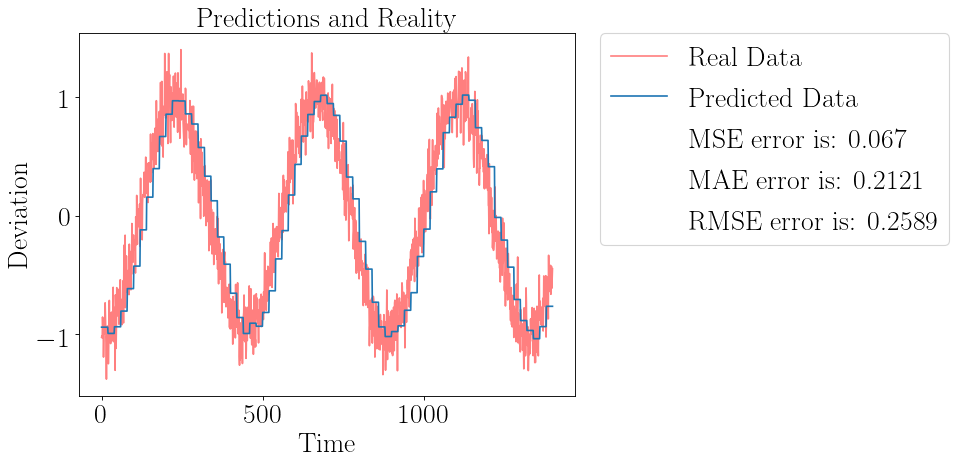

In [6]:
# We can verify if all of the data was prepared correctly, if the baseline calculated here
# Will match the baseline calculated per the experimented methodology system

def baseline(true_dataset, true_labels):
    """
    Description:
    ------------------------------------------------------------------------------------------
    This function creates an artificial baseline to strive to do better than it. All the values
    to predict are equated to the means of what came before (that time step). It is a very naive
    approach, but one that can be made as a baseline to predict how well the neural network does.
    ------------------------------------------------------------------------------------------
    
    Input Parameters:
    ------------------------------------------------------------------------------------------
    > true_dataset = the data from which the predictions need to be made;
    > true_labels  = the true labels of what we want to predict;
    ------------------------------------------------------------------------------------------
    
    Output:
    ------------------------------------------------------------------------------------------
    > pred_collector = predicted data (means)
    > answ_collector = the real data to which the predictions can be compared
    ------------------------------------------------------------------------------------------

    
    """
    # Import packages
    import numpy as np
    
    predicted_from = true_dataset.shape[0] # From how many values to predict
    predicted_to   = true_labels.shape[1]  # How many values to predict
    
    pred_collector = []
    collector_temp = []
    for base in range(predicted_from):
        to_evaluate = np.mean(np.array(true_dataset[base]))
        for itter in range(predicted_to):
            collector_temp.append(to_evaluate)
        pred_collector.append(collector_temp)
        collector_temp = []
        
    collector_temp = None
    pred_collector = np.array(pred_collector) # collection of naive answers 
    
    answ_collector = []
    collector_temp = []
#     print(true_labels[0])
    for base in range(true_labels.shape[0]):
        to_evaluate = np.array(true_labels[base])
        collector_temp.append(to_evaluate)
        answ_collector.append(collector_temp)
        collector_temp = []
        
    collector_temp = []
    answ_collector = np.array(answ_collector)
            
    
    return pred_collector, answ_collector

baseline_predictions, baseline_true = baseline(true_dataset = x_testing,
                                               true_labels  = y_testing)

import numpy as np
FINAL_PREDICTIONS = scaler.inverse_transform(np.array(baseline_predictions).reshape(-1, 1)).reshape(1, -1)[0]
FINAL_REALITY     = scaler.inverse_transform(np.array(baseline_true).reshape(-1, 1)).reshape(1, -1)[0]

#Prepare the accuracy checker here

def accuracy_check(predictions,
                   reality,
                   model,
                   mse=True,
                   mae=False,
                   rmse=False,
                   visualize=False,
                   save_fig=False,
                   logger=False,
                   txt_logger = False,
                   baseline = False):
    """
    Description:
    --------------------------------------------------------------------------------------------------------------
    This function will check the accuracy of predictions by the model to the reality (real data).
    --------------------------------------------------------------------------------------------------------------

    Input Parameters:
    --------------------------------------------------------------------------------------------------------------
    > predictions = a set of data that was predicted by the model (1D tensor);
    > reality     = a set of data that we know is correct (1D tensor);
    > model       = indicate which model was used. Only important if you want to save figures produced;
    > mse         = mean squared error for comparing the accuracy of the data predicted. DEFAULT: True;
    > mae         = mean absoulute error for comparing the accuracy of the data predicted. DEFAULT: False;
    > rmse        = root-mean-squared error for comparing the accuracy of the data predicted. DEFAULT: False;
    > visualize   = show the graphs with all the calculations if chosen. DEFAULT: False;
    > save_fig    = will save the figures produced to pdf for work in LaTeX. DEFAULT: False;
    > logger      = will keep the log of the errors in a txt file. DEFAULT: False;
    > txt_logger  = saves information for the errors in one line of text, for later automatic analysis. DEFAULT: False;
    > baseline    = indicate whether you want to see the accuracy if only baseline predictions are made. In that case
                    insert any value for the model, it will be ignored. Logger is deactivated for it, but the values
                    of the baseline will be saved in the similar format as for the txt_logger. DEFAULT: False;
    --------------------------------------------------------------------------------------------------------------

    Output:
    --------------------------------------------------------------------------------------------------------------
    None
    --------------------------------------------------------------------------------------------------------------
    """
    # Import packages
    import numpy as np

    # Collect all the compariosons
    if mse == True:
        from sklearn.metrics import mean_squared_error
        answer_mse = mean_squared_error(reality, predictions)

    if mae == True:
        from sklearn.metrics import mean_absolute_error
        answer_mae = mean_absolute_error(reality, predictions)

    if rmse == True:
        from sklearn.metrics import mean_squared_error
        from math import sqrt
        answer_rmse = sqrt(mean_squared_error(reality, predictions))

    # Show what is calculated
    if visualize == False:
        if mse == True:
            print("The mse score is: {}".format(np.round(answer_mse, 4)))
        if mae == True:
            print("The mae score is: {}".format(np.round(answer_mae, 4)))
        if rmse == True:
            print("The rmse score is: {}".format(np.round(answer_rmse, 4)))

    else:
        import matplotlib.pyplot as plt
        f = plt.figure(figsize=(8, 6), dpi=80)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        #Adjustments to the font
        MEDIUM_SIZE = 25
        plt.rc('font', size = MEDIUM_SIZE)      
        plt.rc('axes', titlesize = MEDIUM_SIZE)     
        plt.rc('axes', labelsize = MEDIUM_SIZE)    
        plt.rc('xtick', labelsize = MEDIUM_SIZE)    
        plt.rc('ytick', labelsize = MEDIUM_SIZE)    
        plt.rc('legend', fontsize = MEDIUM_SIZE)    
        plt.rc('figure', titlesize = MEDIUM_SIZE)

        if mse == True:
            print("The mse score is: {}".format(np.round(answer_mse, 4)))
        if mae == True:
            print("The mae score is: {}".format(np.round(answer_mae, 4)))
        if rmse == True:
            print("The rmse score is: {}".format(np.round(answer_rmse, 4)))

        plt.plot(reality, alpha=0.5, label="Real Data", color="r")
        plt.plot(predictions, alpha=1, label="Predicted Data")

        if mse == True:
            plt.plot([], [], ' ', label="MSE error is: {}".format((np.round(answer_mse, 4))))
        if mae == True:
            plt.plot([], [], ' ', label=("MAE error is: {}".format(np.round(answer_mae, 4))))
        if rmse == True:
            plt.plot([], [], ' ', label=("RMSE error is: {}".format(np.round(answer_rmse, 4))))

        plt.xlabel("Time", fontsize=MEDIUM_SIZE)
        plt.ylabel("Deviation", fontsize=MEDIUM_SIZE)
        plt.title("Predictions and Reality", fontsize=MEDIUM_SIZE)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        plt.show()

    # Decide if you want to save the outputs visualized in comparison with the errors shown
    if save_fig == True:
        if baseline == False:
            import matplotlib.pyplot as plt
            f = plt.figure(figsize=(8, 6), dpi=80)
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
            
            #Adjustments to the font
            MEDIUM_SIZE = 25
            plt.rc('font', size = MEDIUM_SIZE)      
            plt.rc('axes', titlesize = MEDIUM_SIZE)     
            plt.rc('axes', labelsize = MEDIUM_SIZE)    
            plt.rc('xtick', labelsize = MEDIUM_SIZE)    
            plt.rc('ytick', labelsize = MEDIUM_SIZE)    
            plt.rc('legend', fontsize = MEDIUM_SIZE)    
            plt.rc('figure', titlesize = MEDIUM_SIZE)
            
            plt.plot(reality, alpha=0.5, label="Real Data", color="r")
            plt.plot(predictions, alpha=1, label="Predicted Data")
            if mse == True:
                plt.plot([], [], ' ', label="MSE error is: {}".format((np.round(answer_mse, 4))))
            if mae == True:
                plt.plot([], [], ' ', label=("MAE error is: {}".format(np.round(answer_mae, 4))))
            if rmse == True:
                plt.plot([], [], ' ', label=("RMSE error is: {}".format(np.round(answer_rmse, 4))))
            plt.xlabel("Time", fontsize=MEDIUM_SIZE)
            plt.ylabel("Deviation", fontsize=MEDIUM_SIZE)
            plt.title("Predictions and Reality", fontsize=MEDIUM_SIZE)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
            layers_plt = model.lstm.num_layers  # How many layers were used here
            neurons_plt = model.lstm.hidden_size  # How many neurons were used here
            fname = str("Prediction and Reality _ model uses {} layers, {} neurons.pdf".format(layers_plt, neurons_plt))
            f.savefig(fname, bbox_inches='tight')
            plt.close(f)
            
        if baseline == True:
            import matplotlib.pyplot as plt
            f = plt.figure(figsize=(8, 6), dpi=80)
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
            
            #Adjustments to the font
            MEDIUM_SIZE = 25
            plt.rc('font', size = MEDIUM_SIZE)      
            plt.rc('axes', titlesize = MEDIUM_SIZE)     
            plt.rc('axes', labelsize = MEDIUM_SIZE)    
            plt.rc('xtick', labelsize = MEDIUM_SIZE)    
            plt.rc('ytick', labelsize = MEDIUM_SIZE)    
            plt.rc('legend', fontsize = MEDIUM_SIZE)    
            plt.rc('figure', titlesize = MEDIUM_SIZE)
            
            plt.plot(reality, alpha=0.5, label="Real Data", color="r")
            plt.plot(predictions, alpha=1, label="Predicted Data")
            if mse == True:
                plt.plot([], [], ' ', label="MSE error is: {}".format((np.round(answer_mse, 4))))
            if mae == True:
                plt.plot([], [], ' ', label=("MAE error is: {}".format(np.round(answer_mae, 4))))
            if rmse == True:
                plt.plot([], [], ' ', label=("RMSE error is: {}".format(np.round(answer_rmse, 4))))
            plt.xlabel("Time", fontsize=MEDIUM_SIZE)
            plt.ylabel("Deviation", fontsize=MEDIUM_SIZE)
            plt.title("Predictions and Reality", fontsize=MEDIUM_SIZE)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
            fname = str("Prediction and Reality _ baseline.pdf")
            f.savefig(fname, bbox_inches='tight')
            plt.close(f)
            
    if baseline == True:
        logger = False
    if logger == True:
        import datetime
        import time

        # Create a file and populate it // we can keep a long log by appending the information
        # and just indicating the real time of the log being made to not lose track of what was done
        outF = open("Full Data Log _ Thesis.txt", "a+")

        # Calculate current time
        currentDT = str(datetime.datetime.now())
        time_info = str("\n\nTime of the log made: {}\n".format(currentDT))
        outF.write(time_info)

        # Indicate for which model the calculations are done
        layers_plt = model.lstm.num_layers  # How many layers were used here
        neurons_plt = model.lstm.hidden_size  # How many neurons were used here
        outF.write("Layers: {}, Neurons: {}\n".format(layers_plt, neurons_plt))

        # Fill in the information for the metrics (errors)
        if mse == True:
            outF.write("MSE:  {}\n".format(np.round(answer_mse, 4)))
        if mae == True:
            outF.write("MAE:  {}\n".format(np.round(answer_mae, 4)))
        if rmse == True:
            outF.write("RMSE: {}\n".format(np.round(answer_rmse, 4)))

    if baseline == True:
        txt_logger = False
        outF = open("errors_analysis.txt", "a+")
        string_to_write = str()
        string_to_write = str(0) + (",") + str(0)
        string_to_write = string_to_write + (",") + str(np.round(answer_mse, 4))
        string_to_write = string_to_write + (",") + str(np.round(answer_mae, 4))
        string_to_write = string_to_write + (",") + str(np.round(answer_rmse, 4))
        string_to_write = string_to_write + (",") + ("True") + ("\n")
        outF.write(string_to_write)
        outF.close()
        
    if txt_logger == True:
        outF = open("errors_analysis.txt", "a+")
        string_to_write = str()
        layers_plt = model.lstm.num_layers
        neurons_plt = model.lstm.hidden_size
        string_to_write = str(layers_plt) + (",") + str(neurons_plt)
        if mse == True:
            string_to_write = string_to_write + (",") + str(np.round(answer_mse, 4))
        else:
            string_to_write = string_to_write + (",") + str(-9999)
        if mae == True:
            string_to_write = string_to_write + (",") + str(np.round(answer_mae, 4))
        else:
            string_to_write = string_to_write + (",") + str(-9999)
        if rmse == True:
            string_to_write = string_to_write + (",") + str(np.round(answer_rmse, 4))
        else:
            string_to_write = string_to_write + (",") + str(-9999)
        string_to_write = string_to_write + (",") + ("False")
        string_to_write = string_to_write + ("\n")
        outF.write(string_to_write)
        outF.close()

accuracy_check(predictions = FINAL_PREDICTIONS,
               reality = FINAL_REALITY,
               model = None,
               mse = True,
               mae = True,
               rmse = True,
               visualize = True,
               save_fig = True,
               logger = True,
               txt_logger = True,
               baseline = True)

In [7]:
#Prepare now the model
#This will be a different model so we can re-adjust it if we see fit
def model_build(hidden_nn,
                data_inputs,
                data_targets,
                device,
                num_layers=1,
                dropout=0.0,
                bias=True,
                verify=False):
    """
                                        Description:
    ---------------------------------------------------------------------------------------------
    This function builds a model with which experiments can take place;
    ---------------------------------------------------------------------------------------------

                                      Input Parameters:
    ---------------------------------------------------------------------------------------------
    > hidden_nn    = how many hidden neurons will the network layers have;
    > data_input   = how many data points are feed as inputs;
    > data_targets = how many values have to be predicted (i.e. final outputs);
    > device       = to what device will data be transfered for training;
    > num_layers   = amount of layers a network will have. DEFAULT: 1;
    > dropout      = if the network has more than 1 layer, a dropout of neurons per training could
                     be indicated. DEFAULT: 0.0
    > bias         = should all layers have bias turned on or not. DEFAULT: True
    > verify       = show information indicating what kind of network was created. DEFAULT: False
    ---------------------------------------------------------------------------------------------

                                           Output:
    ---------------------------------------------------------------------------------------------
    > model = a structure of the network
    ---------------------------------------------------------------------------------------------
    """

    # Import packages
    import torch
    import torch.nn as nn
    import numpy as np

    # Make values re-assignment (due to legacy build)
    NUM_LAYERS = num_layers
    HIDDEN_NN = hidden_nn
    INITIAL_DATA = data_inputs
    PRED_DATA = data_targets
    DROPOUT = dropout
    BIAS = bias

    # Create a network
    class LSTM_NN(nn.Module):

        def __init__(self,
                     viz=False,  # Will indicate whether we should visualize the transformed tensors
                     t_pass=[]):  # Collects and holds data to visualize outputs
            super(LSTM_NN, self).__init__()
            # Several Misc items
            self.viz = viz
            self.t_pass = t_pass

            # This is an lstm layer representative
            self.lstm = nn.LSTM(input_size=1,  # How many values sequentially will be fed into it
                                hidden_size=HIDDEN_NN,  # How many neurons there are in the layer
                                num_layers=NUM_LAYERS,  # How many layers are there in the network
                                bias=BIAS,  # Will the bias be present
                                dropout=DROPOUT,  # With one layer we will always have a 0.0 dropout
                                batch_first=True,  # Initiate for batch to go as the first value
                                bidirectional=False)  # Turn off the biderectional function

            # This is the output layer representative
            self.fc = nn.Linear(in_features=HIDDEN_NN * INITIAL_DATA,  # How many cells will output their values
                                out_features=PRED_DATA,  # How many values are we predicting
                                bias=BIAS)  # Will the associated bias be counted

        def forward(self, t):
            if self.viz == False:
                # Initial input layer (0)
                batch_size, _, _ = t.size()  # Batch size will change in the end, so we need an internal tracker of it
                t = t  # (batch, initial time steps, #variables)

                # Set initial hidden and general cells states
                h0 = torch.zeros(NUM_LAYERS, batch_size, HIDDEN_NN, dtype=torch.double).to(device)  # (layers, batch, neurons)
                c0 = torch.zeros(NUM_LAYERS, batch_size, HIDDEN_NN, dtype=torch.double).to(device)  # (layers, batch, neurons)

                # Forward propogate LSTM
                out, (hn, cn) = self.lstm(t, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
                # print(out)  # Batch x #Inputs x #Neurons

                out = out.contiguous().view(batch_size, -1)  # Otherwise we get a matrix of  Batch x #Inputs x #Neurons
                # But this way now we get Batch x Inputs*Neurons

                # Decode the hidden state of the last time step
                out = self.fc(out)  # (Batch, Predicted Time Steps)
                return out

            elif self.viz == True:
                # This will activate if we make predictions and want to visualize them
                batch_size, _, _ = t.size()
                t = t

                h0 = torch.zeros(NUM_LAYERS, batch_size, HIDDEN_NN, dtype=torch.double).to(device)
                c0 = torch.zeros(NUM_LAYERS, batch_size, HIDDEN_NN, dtype=torch.double).to(device)

                out, (hn, cn) = self.lstm(t, (h0, c0))

                viz_copy = out.cpu().numpy()  # We need an internal temporary storage of original outputs
                # As they are far easier to work with

                # This further small function sums the outputs of cells in a neuron
                # The mutual sum is compared to what the other neurons produce
                # Comparison is done through summing of all neuron outputs (cells are summed with absolute values)
                # The summed values are divided by the total amount of outputs summed
                # All transformation become percentages that in total sum to 1 (or 100%)
                # DISCLAIMER: Softmax would produce a similar output, but variation would differ slightly
                # First pass is saved into a t_pass list holder
                for batch_entry in viz_copy:
                    neurons_collector = []
                    for neurons_entry in batch_entry.T:
                        neurons_collector.append(np.std(neurons_entry))
                    neurons_collector = np.array(neurons_collector)
                    signal_proc = neurons_collector / neurons_collector.sum()
                    self.t_pass.append(signal_proc)

                out = out.contiguous().view(batch_size, -1)
                out = self.fc(out)
                return out

        def retrieve_signal(self):
            """Return the tensor transformation visualization dataframe."""
            return np.array(self.t_pass)

        def clean_signal(self):
            """Clean the data stored from previous visualization attemtps."""
            self.t_pass = []

    model = LSTM_NN().to(device)
    model = model.double()

    if verify == True:
        print(model)

    return model

model = model_build(hidden_nn = 256, 
                    data_inputs = 20, 
                    data_targets = 20, 
                    device = device,
                    num_layers = 1,
                    dropout = 0.0,
                    bias = True,
                    verify = True)

# For more control the following parameters are seperate:
import torch
import torch.nn as nn
import torch.optim as optim

CRITERION = nn.MSELoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=1e-3)

LSTM_NN(
  (lstm): LSTM(1, 256, batch_first=True)
  (fc): Linear(in_features=5120, out_features=20, bias=True)
)


In [8]:
#Now the crux of this model. The training part under different criteria
#Here we need to aim to induce sparsity of roughly 99.2188% from the original network that was initiated
#This is done through trial and error in setting out the correct specifications for the epochs and train/re-train epochs

def training_init(model,
                  train_loader,
                  epochs,
                  data_input,
                  data_targets,
                  device,
                  criterion,
                  optimizer,
                  frequency=500,
                  verbose=0,
                  stage_one_pruning = 0.1,
                  stage_two_pruning = 0.5,
                  stage_three_pruning = 0.4,
                  pruning_perc = 0.1):
    """
                                                    Description:
    ---------------------------------------------------------------------------------------------------------
    Initialize the training of the network required
    ---------------------------------------------------------------------------------------------------------

                                                  Input Parameters:
    ---------------------------------------------------------------------------------------------------------
    > model        = the instance of the model/network we want to work with;
    > train_loader = train_loader that will be used to feed in data into the network;
    > epochs       = amount of epochs for which our network will train;
    > data_input   = how many values are used to make predictions on
    > data_targets = how many values are needed to be predicted
    > device       = what device do you want to move your information to;
    > criterion    = type of loss calculation system that you want to use;
    > optimizer    = type of an optimizer you want to use in your network;
    > frequency    = how often updates on each epoch finishing proceeding should show. DEFAULT: 500;
    > verbose      = 0 - do not show any information on the progress except which epoch is running,
                     1 - only show the epochs running and how many instances per epoch already ran,
                     2 - show epochs running and the time,
                     3 - show only the time it took to train the network,
                     DEFAULT: 0;
                     
    PRESENT IN ALTERNATIVE BASELINE MODEL
    If the following three parameters do not add up to 1, the network will not train.
    > stage_one_pruning   = how many epochs are dedicated out of all provided to initial standard net training.
                            DEFAULT: 0.1;
    > stage_two_pruning   = how many epochs are dedicated to pruning of weights over them. DEFAULT: 0.5;
    > stage_three_pruning = how many epochs are dedicated to re-training of the network when all connections
                            that were required have already been prunned. DEFAULT: 0.4.
                            
    > pruning_perc        = How much of the network's fc weights do we want to prune. DEFAULT: 0.1. If the required
                            amount will not be a real integer for the weights (e.g 10% = 3.6 weights), then the
                            amount of weights will be taken as the int value (e.g. int(3.6) = 3).
    ---------------------------------------------------------------------------------------------------------

                                                       Output:
    ---------------------------------------------------------------------------------------------------------
    > model = model after training, but it will update from the global environment
    ---------------------------------------------------------------------------------------------------------
    """
    if stage_one_pruning + stage_two_pruning + stage_three_pruning != 1:
        print("Sum of time on all stages does not equal to one.")
        return
    
#     print(model.fc.weight.data) # These are our weights (Matrix with fully connected layer)

    # Import packages
    import time
    import numpy as np

    import torch
    import torch.nn as nn
    import torchvision.transforms as transforms
    import torch.optim as optim
    import torch.utils.data as data_utils
    
    seed_value = 42
    torch.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)

    # Re-assign values to help keep track of few things
    model = model
    train_loader = train_loader
    EPOCHS = epochs
    INITIAL_DATA = data_input
    PRED_DATA = data_targets
    frequency = frequency
    verbose = verbose
    pruning_perc = pruning_perc
    
    # Prepare data for how many epochs will we have to train-prune-retrain stages
    EPOCHS_STG1 = int(EPOCHS * stage_one_pruning)
    EPOCHS_STG2 = int(EPOCHS * stage_two_pruning)
    EPOCHS_STG3 = EPOCHS - EPOCHS_STG1 - EPOCHS_STG2
    EPOCHS_SEQ  = (EPOCHS_STG1, 
                   EPOCHS_STG1 + EPOCHS_STG2,
                   EPOCHS_STG1 + EPOCHS_STG2 + EPOCHS_STG3) #Until when the stages go for epochs
    
    # We need to track wich epoch is which
    # These will give us treshold to know when to initialize one or the other step
    EPOCHS_STG1_LIST = [x for x in range(0, EPOCHS)][:EPOCHS_SEQ[0]]
    EPOCHS_STG2_LIST = [x for x in range(0, EPOCHS)][EPOCHS_SEQ[0]:EPOCHS_SEQ[1]]
    EPOCHS_STG3_LIST = [x for x in range(0, EPOCHS)][EPOCHS_SEQ[1]:]
    
    print("Training will take \t{} Epochs".format(EPOCHS_STG1))
    print("Pruning will take \t{} Epochs".format(EPOCHS_STG2))
    print("Re-training will take \t{} Epochs".format(EPOCHS_STG3))
    
    #We need to calculate how many weights will we be able to prune with the criteria we are given for pruning
    to_prune = int(len(model.fc.weight.data.flatten())* pruning_perc) #Real amount of weights that we desire to prune  
    
    model.viz = False  # Turn of the vizualization component of layers
    model.train()  # Put the model into the training state
    total_step = len(train_loader)
    start = time.time()  # Time how long it takes to execute the training
    print("Training initiated")
    
    # TRAIN OUR MODEL IN 3 STAGES
    
    # The stages for updating of the mask and the grid are called beforehand, so that we do not need to account for loop
    # Like calculations in the training stages. They will eitherway not come into play, until we initialize the second
    # stage of training to happen
    
    every_update = int(to_prune/len(train_loader)) #Indicate, by how many values should each update be followed
    to_prune = int(to_prune/len(train_loader)) * len(train_loader) #Indication of how many weights do we need to prune by the end
    
    tracker_time = 0 #To know when our data has to be updated with the grid per the amount of time we are giving
                     #It gets +1 to the counter with every step in training done through all the stage 2 epochs
                     # total steps will helps us indicate when our updates need to kick in
    
    tracker_updater = 0 # Starts with 0 and will go to the amount of values we need to mask 
    
    #Find out how often each update needs to take place
    if (total_step * EPOCHS_STG2 / to_prune) >= 1:
        every_update = int(total_step * EPOCHS_STG2 / to_prune)
    else:
        every_update = int(1)
        
    #By how much values mask updates need to expand
    if (total_step * EPOCHS_STG2 / to_prune) >= 1:
        to_update = int(1)
    else:
        to_update = int(np.ceil(1 / (total_step * EPOCHS_STG2 / to_prune)))
        
        
    print("The real amount of weights that will be pruned: {}/{}, equating to true {}%\n".format(int(to_update/every_update*total_step * EPOCHS_STG2),
                                                                                                 len(model.fc.weight.data.flatten()),
                                                                                                 np.round(100 * (to_update/every_update*total_step * EPOCHS_STG2)/(len(model.fc.weight.data.flatten()))),2))
    
    print("------SUMMARY------")
    print("We have: {} time steps per one EPOCH".format(total_step))
    print("We have {} steps per STAGE 2 EPOCHS".format(EPOCHS_STG2))
    print("Multiplying above values will give: {}".format(total_step * EPOCHS_STG2))
    
    print("We need to prune: {} connection".format(to_prune))
    print("That means we need to make an update every: {}".format(total_step * EPOCHS_STG2 / to_prune))
    
    print("We currently make an update every: {} step".format(every_update))
    print("We are currently making: {} connection updates per step".format(to_update))
    print()
        
    #Now semantics to prepare our mask  
    #How many values we will have to enter for in the weights
    first_wegiths_dim  = PRED_DATA                             #Number of outputs
    second_weights_dim = INITIAL_DATA * model.lstm.hidden_size #Number of connections each unit produces
    #And create from above information the set of all possible combinations of weights we might need
    draft = [(x, y) for x in range(0, first_wegiths_dim) for y in range(0, second_weights_dim)] 
    
    #We need list that we will update itterativelly as masks
    pruned_dim_one = [] 
    pruned_dim_two = []
    masking        = [pruned_dim_one, pruned_dim_two]
    #Mask will be created and updated during the second stage of the training procedure
    #Mask can be applied straight away, as if it is just two empty lists inside of the mask - nothing will be updated
    
    
    
    
    for epoch in range(EPOCHS):
        # -----------------------------------------------------------------------------------------------------------
        # Stage 1 Will be default style training. Nothing has to be adjusted here, we do need to account for only how
        # Many epochs this training takes place
        if epoch in EPOCHS_STG1_LIST:
            print("TRAINING EPOCH ONGOING")
            #This will be a standard initial training procedure (STAGE 1)
            if verbose != 3:
                print("EPOCH: {}".format(epoch + 1))

            for i, (data_epochs, labels_epochs) in enumerate(train_loader):
                # REPREPARE THE DATA AS WE NEED TO RESHAPE IT AT THIS POINT TO A 3D TENSOR
                data_epochs = data_epochs.reshape(-1, INITIAL_DATA, 1).to(device)  # (batch, initial time steps, #variables)
                labels_epochs = labels_epochs.reshape(-1, PRED_DATA).to(device)  # (batch, predicted time steps)

                # FORWARD THE LEARING PROCESS THEN NOW
                outputs = model(data_epochs)
                loss = criterion(outputs, labels_epochs)

                # BACKWARDS AND OPTIMIZE
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if verbose == 2 or verbose == 1:
                    if (i + 1) % frequency == 0:
                        print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                              .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item()))
            if verbose == 2 or verbose == 1:
                print()
                
        # -----------------------------------------------------------------------------------------------------------
        if epoch in EPOCHS_STG2_LIST:
            print("PRUNING EPOCH ONGOING")
            #This will initialize the procedure when the weights are prunned (STAGE 2)
            #MASK WILL BE APPLIED TO WEIGHTS AND TO THE GRADIENT
            if verbose != 3:
                print("EPOCH: {}".format(epoch + 1))

            for i, (data_epochs, labels_epochs) in enumerate(train_loader):
                data_epochs = data_epochs.reshape(-1, INITIAL_DATA, 1).to(device)
                labels_epochs = labels_epochs.reshape(-1, PRED_DATA).to(device)

                # FORWARD THE LEARING PROCESS THEN NOW
                outputs = model(data_epochs)
                loss = criterion(outputs, labels_epochs)

                # BACKWARDS AND OPTIMIZE
                optimizer.zero_grad()
                loss.backward()
                
                #Perform the mask application to the weights and to the gradient that will go on the backwards propogation
                model.fc.weight.data[masking] = 0.0
                model.fc.weight.grad[masking] = 0.0
                optimizer.step()
                
                # Add value to our steps tracker
                tracker_time += 1
                #Check if the weights need to be updated now
                if tracker_time >= every_update:
                    tracker_time = 0 #Reset the updates tracker
                    tracker_updater += 1 # +1 additional weight is added to the mask and will be calculated
                    
                    #Update and/or create our mask for the training with zeros
                    #Sort all weigths as they changed during training that has went on
                    smallest_highest_weights = np.argsort(np.absolute(model.fc.weight.data.cpu()), axis = None) 
                    #This will in itterative fashion update
                    pruned_dim_one = []
                    pruned_dim_two = []
                    for value in smallest_highest_weights[:tracker_updater * to_update]:
                        #Clean mask dimensions as they will constantly be updated
                        #Populate masking info
                        pruned_dim_one.append(draft[value][0])
                        pruned_dim_two.append(draft[value][1])
                    masking = [pruned_dim_one, pruned_dim_two]

                    

                if verbose == 2 or verbose == 1:
                    if (i + 1) % frequency == 0:
                        print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                              .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item()))
            if verbose == 2 or verbose == 1:
                print()
                
        # -----------------------------------------------------------------------------------------------------------
        if epoch in EPOCHS_STG3_LIST:
            print("RE-TRAINING EPOCH ONGOING")
            #This will initialize the procedure of re-trainings (STAGE 3)
            #MASK WILL BE APPLIED ONLY TO THE GRADIENT IN HOPES OUR NEEDED WEIGHTS ARE STAYING THE SAME
            if verbose != 3:
                print("EPOCH: {}".format(epoch + 1))

            for i, (data_epochs, labels_epochs) in enumerate(train_loader):
                data_epochs = data_epochs.reshape(-1, INITIAL_DATA, 1).to(device)
                labels_epochs = labels_epochs.reshape(-1, PRED_DATA).to(device)

                # FORWARD THE LEARING PROCESS THEN NOW
                outputs = model(data_epochs)
                loss = criterion(outputs, labels_epochs)

                # BACKWARDS AND OPTIMIZE
                optimizer.zero_grad()
                loss.backward()
                
                # THIS one is simple. Purelly retain the mask from the previous step but allow the network to re-train
                # No fancy calculations are needed at this stage
                model.fc.weight.data[masking] = 0.0
                model.fc.weight.grad[masking] = 0.0
                optimizer.step()

                if verbose == 2 or verbose == 1:
                    if (i + 1) % frequency == 0:
                        print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                              .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item()))
            if verbose == 2 or verbose == 1:
                print()

    print("Training finished")
    end = time.time()
    final = end - start
    final_time = np.round(final / 60, 2)
    if verbose == 2 or verbose == 3:
        print("It took the network: {} minutes to train.".format(final_time))
        

training_init(model = model,
              train_loader = train_loader,
              epochs = 19, #Dropped by one to fit the narative of the training
              data_input = 20,
              data_targets = 20,
              device = device,
              criterion = CRITERION,
              optimizer = OPTIMIZER,
              frequency = 500,
              verbose = 2,
              stage_one_pruning = 0.1,
              stage_two_pruning = 0.4,
              stage_three_pruning = 0.5,
              pruning_perc = 0.992188)   # aiming for roughly 99.2188%
                                         # should get roughly 98.82% with what we have

Training will take 	1 Epochs
Pruning will take 	7 Epochs
Re-training will take 	11 Epochs
Training initiated
The real amount of weights that will be pruned: 101192/102400, equating to true 99.0%

------SUMMARY------
We have: 1112 time steps per one EPOCH
We have 7 steps per STAGE 2 EPOCHS
Multiplying above values will give: 7784
We need to prune: 101192 connection
That means we need to make an update every: 0.07692307692307693
We currently make an update every: 1 step
We are currently making: 13 connection updates per step

TRAINING EPOCH ONGOING
EPOCH: 1
Epoch [1/19], Step [500/1112], Loss: 0.0047
Epoch [1/19], Step [1000/1112], Loss: 0.0041

PRUNING EPOCH ONGOING
EPOCH: 2
Epoch [2/19], Step [500/1112], Loss: 0.0042
Epoch [2/19], Step [1000/1112], Loss: 0.0056

PRUNING EPOCH ONGOING
EPOCH: 3
Epoch [3/19], Step [500/1112], Loss: 0.0037
Epoch [3/19], Step [1000/1112], Loss: 0.0041

PRUNING EPOCH ONGOING
EPOCH: 4
Epoch [4/19], Step [500/1112], Loss: 0.0031
Epoch [4/19], Step [1000/1112],

In [9]:
# Make a visual evaluation of weights we have currently
model.fc.weight.data
#We would like to equate very small one to zeros, if python sees them as close to zeros

tensor([[-1.4205e-318,  8.6629e-319,  4.3970e-319,  ...,  2.2507e-319,
          1.1885e-318, -1.0508e-318],
        [-1.9832e-318, -1.8842e-318,  2.9006e-319,  ...,  1.2651e-319,
          1.0009e-318, -1.2397e-318],
        [ 1.9343e-318,  7.5755e-319,  2.9056e-319,  ...,  1.2425e-319,
          1.3052e-318, -8.7744e-319],
        ...,
        [ 1.3262e-318, -1.6796e-318,  3.7595e-319,  ...,  -2.5795e-01,
          9.2433e-319, -9.5824e-319],
        [-1.9383e-318, -1.8305e-318,  5.5082e-319,  ...,  -2.2965e-01,
          9.0829e-319, -7.9776e-319],
        [ 1.9471e-318,  1.0198e-318,  6.4839e-319,  ...,  -2.7832e-01,
          8.4413e-319,  9.2142e-319]], device='cuda:0', dtype=torch.float64)

In [10]:
# print(model.fc.weight.data)
#Overwrite the original weights
#Matrix of zeros, as big as our model
z = np.zeros(len(model.fc.weight.data.flatten())).reshape(np.array(model.fc.weight.data.cpu().numpy()).shape[0], 
                                                          np.array(model.fc.weight.data.cpu().numpy()).shape[1])

original_M      = model.fc.weight.data.cpu().numpy() #Make a back-up copy
copy_original_M = model.fc.weight.data.cpu().numpy() #Make a variable for storing weights
copy_original_M[np.isclose(model.fc.weight.data.cpu().numpy(),z)] = 0 #Transform small weights to zeros
model.fc.weight.data = torch.from_numpy(copy_original_M) #Return weights matrix with zeros to the tendor
model.fc.weight.data.to(device) #Move everything back to the device on which we are training
model.to(device) #Move the model with updated weights to the device as well

LSTM_NN(
  (lstm): LSTM(1, 256, batch_first=True)
  (fc): Linear(in_features=5120, out_features=20, bias=True)
)

In [11]:
#Verify how many values are small enough that python sees it as being almost equal to zero
np.count_nonzero(np.isclose(model.fc.weight.data.cpu().numpy(),z))
#We transformed exactly the amount we wanted

101192

In [12]:
#Another look at the updated weights can be made
model.fc.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.2579,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.2296,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.2783,  0.0000,  0.0000]],
       device='cuda:0', dtype=torch.float64)

The mse score is: 0.0358
The mae score is: 0.1497
The rmse score is: 0.1892


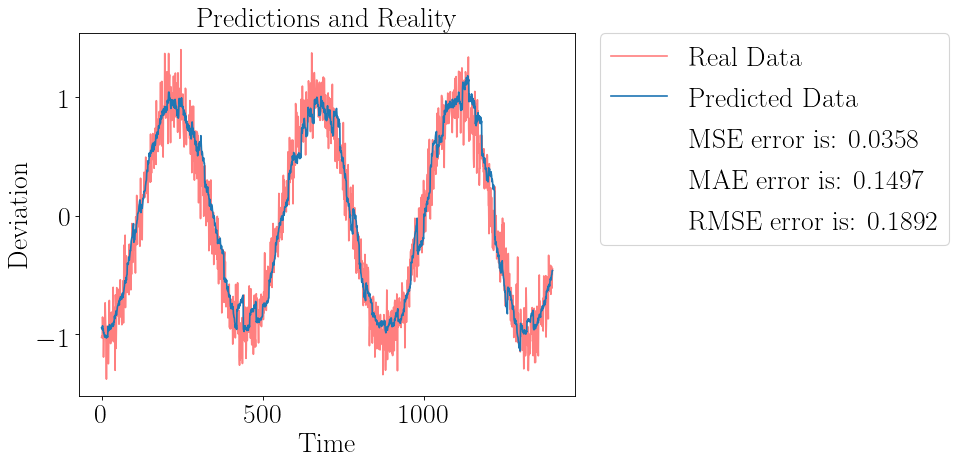

In [13]:
#See if the model works
def testing_init(model,
                 test_loader,
                 input_data,
                 device):
    """
                                                Description:
    -----------------------------------------------------------------------------------------------------------
    Initiate the testing of the model.
    -----------------------------------------------------------------------------------------------------------

                                              Input Parameters:
    -----------------------------------------------------------------------------------------------------------
    > model       = model that will be used for data evaluation;
    > test_loader = loader that will load our information in batches;
    > input_data  = how many values are used to make predictions on;
    > device      = what device do you want to load the information to;
    -----------------------------------------------------------------------------------------------------------

                                                   Output:
    -----------------------------------------------------------------------------------------------------------
    > final_answers = a set of data that our model produces;
    > final_data    = a set of data that we know is correct and to which our answers can be compared to;
    -----------------------------------------------------------------------------------------------------------
    """
    # Updated due to legacy connections
    INITIAL_DATA = input_data

    # Import needed packages
    import time
    import numpy as np

    import torch
    import torch.nn as nn
    import torchvision.transforms as transforms
    import torch.optim as optim
    import torch.utils.data as data_utils

    model.viz = True
    model.clean_signal()
    model.eval()

    # Predict the data with the model we have
    with torch.no_grad():
        answers = []  # Answers that our model produces
        data_known = []  # Real Answers that we know

        for data_testing, labels_testing in (test_loader):
            data_testing = data_testing.reshape(-1, INITIAL_DATA, 1).to(device)
            labels_testing = labels_testing.to(device)

            outputs = model(data_testing)
            answers.append(outputs)
            data_known.append(labels_testing)
            
        
        PRED_DATA = labels_testing.shape[1]
        if PRED_DATA == 1:
            # Data that we predict
            final_answers = []
            for i in range(len(answers)):
                for i2 in range(len(answers[i])):
        #             for i3 in range(len(answers[i][i2])):
                    final_answers.append(answers[i][i2].cpu().numpy())
            final_answers = np.array(final_answers)

            # Data that we know to which we can compare our answers to
            final_data = []
            for i in range(len(data_known)):
                for i2 in range(len(data_known[i])):
        #             for i3 in range(len(data_known[i][i2])):
                    final_data.append(data_known[i][i2].cpu().numpy())
            final_data = np.array(final_data)

            return final_answers, final_data
        
        elif PRED_DATA > 1:
                        # Data that we predict
            final_answers = []
            for i in range(len(answers)):
                for i2 in range(len(answers[i])):
                    for i3 in range(len(answers[i][i2])):
                        final_answers.append(answers[i][i2][i3].cpu().numpy())
            final_answers = np.array(final_answers)

            # Data that we know to which we can compare our answers to
            final_data = []
            for i in range(len(data_known)):
                for i2 in range(len(data_known[i])):
                    for i3 in range(len(data_known[i][i2])):
                        final_data.append(data_known[i][i2][i3].cpu().numpy())
            final_data = np.array(final_data)

            return final_answers, final_data
        

predictions, reality = testing_init(model = model,
                                    test_loader = test_loader,
                                    input_data = 20,
                                    device = device)

import numpy as np
FINAL_PREDICTIONS = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(1, -1)[0]
FINAL_REALITY     = scaler.inverse_transform(np.array(reality).reshape(-1, 1)).reshape(1, -1)[0]

def accuracy_check(predictions,
                   reality,
                   model,
                   mse=True,
                   mae=False,
                   rmse=False,
                   visualize=False,
                   save_fig=False,
                   logger=False,
                   txt_logger = False,
                   baseline = False):
    """
    Description:
    --------------------------------------------------------------------------------------------------------------
    This function will check the accuracy of predictions by the model to the reality (real data).
    --------------------------------------------------------------------------------------------------------------

    Input Parameters:
    --------------------------------------------------------------------------------------------------------------
    > predictions = a set of data that was predicted by the model (1D tensor);
    > reality     = a set of data that we know is correct (1D tensor);
    > model       = indicate which model was used. Only important if you want to save figures produced;
    > mse         = mean squared error for comparing the accuracy of the data predicted. DEFAULT: True;
    > mae         = mean absoulute error for comparing the accuracy of the data predicted. DEFAULT: False;
    > rmse        = root-mean-squared error for comparing the accuracy of the data predicted. DEFAULT: False;
    > visualize   = show the graphs with all the calculations if chosen. DEFAULT: False;
    > save_fig    = will save the figures produced to pdf for work in LaTeX. DEFAULT: False;
    > logger      = will keep the log of the errors in a txt file. DEFAULT: False;
    > txt_logger  = saves information for the errors in one line of text, for later automatic analysis. DEFAULT: False;
    > baseline    = indicate whether you want to see the accuracy if only baseline predictions are made. In that case
                    insert any value for the model, it will be ignored. Logger is deactivated for it, but the values
                    of the baseline will be saved in the similar format as for the txt_logger. DEFAULT: False;
    --------------------------------------------------------------------------------------------------------------

    Output:
    --------------------------------------------------------------------------------------------------------------
    None
    --------------------------------------------------------------------------------------------------------------
    """
    # Import packages
    import numpy as np

    # Collect all the compariosons
    if mse == True:
        from sklearn.metrics import mean_squared_error
        answer_mse = mean_squared_error(reality, predictions)

    if mae == True:
        from sklearn.metrics import mean_absolute_error
        answer_mae = mean_absolute_error(reality, predictions)

    if rmse == True:
        from sklearn.metrics import mean_squared_error
        from math import sqrt
        answer_rmse = sqrt(mean_squared_error(reality, predictions))

    # Show what is calculated
    if visualize == False:
        if mse == True:
            print("The mse score is: {}".format(np.round(answer_mse, 4)))
        if mae == True:
            print("The mae score is: {}".format(np.round(answer_mae, 4)))
        if rmse == True:
            print("The rmse score is: {}".format(np.round(answer_rmse, 4)))

    else:
        import matplotlib.pyplot as plt
        f = plt.figure(figsize=(8, 6), dpi=80)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        #Adjustments to the font
        MEDIUM_SIZE = 25
        plt.rc('font', size = MEDIUM_SIZE)      
        plt.rc('axes', titlesize = MEDIUM_SIZE)     
        plt.rc('axes', labelsize = MEDIUM_SIZE)    
        plt.rc('xtick', labelsize = MEDIUM_SIZE)    
        plt.rc('ytick', labelsize = MEDIUM_SIZE)    
        plt.rc('legend', fontsize = MEDIUM_SIZE)    
        plt.rc('figure', titlesize = MEDIUM_SIZE)

        if mse == True:
            print("The mse score is: {}".format(np.round(answer_mse, 4)))
        if mae == True:
            print("The mae score is: {}".format(np.round(answer_mae, 4)))
        if rmse == True:
            print("The rmse score is: {}".format(np.round(answer_rmse, 4)))

        plt.plot(reality, alpha=0.5, label="Real Data", color="r")
        plt.plot(predictions, alpha=1, label="Predicted Data")

        if mse == True:
            plt.plot([], [], ' ', label="MSE error is: {}".format((np.round(answer_mse, 4))))
        if mae == True:
            plt.plot([], [], ' ', label=("MAE error is: {}".format(np.round(answer_mae, 4))))
        if rmse == True:
            plt.plot([], [], ' ', label=("RMSE error is: {}".format(np.round(answer_rmse, 4))))

        plt.xlabel("Time", fontsize=MEDIUM_SIZE)
        plt.ylabel("Deviation", fontsize=MEDIUM_SIZE)
        plt.title("Predictions and Reality", fontsize=MEDIUM_SIZE)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        plt.show()

    # Decide if you want to save the outputs visualized in comparison with the errors shown
    if save_fig == True:
        if baseline == False:
            import matplotlib.pyplot as plt
            f = plt.figure(figsize=(8, 6), dpi=80)
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
            
            #Adjustments to the font
            MEDIUM_SIZE = 25
            plt.rc('font', size = MEDIUM_SIZE)      
            plt.rc('axes', titlesize = MEDIUM_SIZE)     
            plt.rc('axes', labelsize = MEDIUM_SIZE)    
            plt.rc('xtick', labelsize = MEDIUM_SIZE)    
            plt.rc('ytick', labelsize = MEDIUM_SIZE)    
            plt.rc('legend', fontsize = MEDIUM_SIZE)    
            plt.rc('figure', titlesize = MEDIUM_SIZE)
            
            plt.plot(reality, alpha=0.5, label="Real Data", color="r")
            plt.plot(predictions, alpha=1, label="Predicted Data")
            if mse == True:
                plt.plot([], [], ' ', label="MSE error is: {}".format((np.round(answer_mse, 4))))
            if mae == True:
                plt.plot([], [], ' ', label=("MAE error is: {}".format(np.round(answer_mae, 4))))
            if rmse == True:
                plt.plot([], [], ' ', label=("RMSE error is: {}".format(np.round(answer_rmse, 4))))
            plt.xlabel("Time", fontsize=MEDIUM_SIZE)
            plt.ylabel("Deviation", fontsize=MEDIUM_SIZE)
            plt.title("Predictions and Reality", fontsize=MEDIUM_SIZE)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
            layers_plt = model.lstm.num_layers  # How many layers were used here
            neurons_plt = model.lstm.hidden_size  # How many neurons were used here
            fname = str("Prediction and Reality _ model uses {} layers, {} neurons.pdf".format(layers_plt, neurons_plt))
            f.savefig(fname, bbox_inches='tight')
            plt.close(f)
            
        if baseline == True:
            import matplotlib.pyplot as plt
            f = plt.figure(figsize=(8, 6), dpi=80)
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
            
            #Adjustments to the font
            MEDIUM_SIZE = 25
            plt.rc('font', size = MEDIUM_SIZE)      
            plt.rc('axes', titlesize = MEDIUM_SIZE)     
            plt.rc('axes', labelsize = MEDIUM_SIZE)    
            plt.rc('xtick', labelsize = MEDIUM_SIZE)    
            plt.rc('ytick', labelsize = MEDIUM_SIZE)    
            plt.rc('legend', fontsize = MEDIUM_SIZE)    
            plt.rc('figure', titlesize = MEDIUM_SIZE)
            
            plt.plot(reality, alpha=0.5, label="Real Data", color="r")
            plt.plot(predictions, alpha=1, label="Predicted Data")
            if mse == True:
                plt.plot([], [], ' ', label="MSE error is: {}".format((np.round(answer_mse, 4))))
            if mae == True:
                plt.plot([], [], ' ', label=("MAE error is: {}".format(np.round(answer_mae, 4))))
            if rmse == True:
                plt.plot([], [], ' ', label=("RMSE error is: {}".format(np.round(answer_rmse, 4))))
            plt.xlabel("Time", fontsize=MEDIUM_SIZE)
            plt.ylabel("Deviation", fontsize=MEDIUM_SIZE)
            plt.title("Predictions and Reality", fontsize=MEDIUM_SIZE)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
            fname = str("Prediction and Reality _ baseline.pdf")
            f.savefig(fname, bbox_inches='tight')
            plt.close(f)
            
    if baseline == True:
        logger = False
    if logger == True:
        import datetime
        import time

        # Create a file and populate it // we can keep a long log by appending the information
        # and just indicating the real time of the log being made to not lose track of what was done
        outF = open("Full Data Log _ Thesis.txt", "a+")

        # Calculate current time
        currentDT = str(datetime.datetime.now())
        time_info = str("\n\nTime of the log made: {}\n".format(currentDT))
        outF.write(time_info)

        # Indicate for which model the calculations are done
        layers_plt = model.lstm.num_layers  # How many layers were used here
        neurons_plt = model.lstm.hidden_size  # How many neurons were used here
        outF.write("Layers: {}, Neurons: {}\n".format(layers_plt, neurons_plt))

        # Fill in the information for the metrics (errors)
        if mse == True:
            outF.write("MSE:  {}\n".format(np.round(answer_mse, 4)))
        if mae == True:
            outF.write("MAE:  {}\n".format(np.round(answer_mae, 4)))
        if rmse == True:
            outF.write("RMSE: {}\n".format(np.round(answer_rmse, 4)))

    if baseline == True:
        txt_logger = False
        outF = open("errors_analysis.txt", "a+")
        string_to_write = str()
        string_to_write = str(0) + (",") + str(0)
        string_to_write = string_to_write + (",") + str(np.round(answer_mse, 4))
        string_to_write = string_to_write + (",") + str(np.round(answer_mae, 4))
        string_to_write = string_to_write + (",") + str(np.round(answer_rmse, 4))
        string_to_write = string_to_write + (",") + ("True") + ("\n")
        outF.write(string_to_write)
        outF.close()
        
    if txt_logger == True:
        outF = open("errors_analysis.txt", "a+")
        string_to_write = str()
        layers_plt = model.lstm.num_layers
        neurons_plt = model.lstm.hidden_size
        string_to_write = str(layers_plt) + (",") + str(neurons_plt)
        if mse == True:
            string_to_write = string_to_write + (",") + str(np.round(answer_mse, 4))
        else:
            string_to_write = string_to_write + (",") + str(-9999)
        if mae == True:
            string_to_write = string_to_write + (",") + str(np.round(answer_mae, 4))
        else:
            string_to_write = string_to_write + (",") + str(-9999)
        if rmse == True:
            string_to_write = string_to_write + (",") + str(np.round(answer_rmse, 4))
        else:
            string_to_write = string_to_write + (",") + str(-9999)
        string_to_write = string_to_write + (",") + ("False")
        string_to_write = string_to_write + ("\n")
        outF.write(string_to_write)
        outF.close()

#And check the accuracy
accuracy_check(predictions = FINAL_PREDICTIONS,
               reality = FINAL_REALITY,
               model = model,
               mse = True,
               mae = True,
               rmse = True,
               visualize = True,
               save_fig = True,
               logger = True,
               txt_logger = True,
               baseline = False)

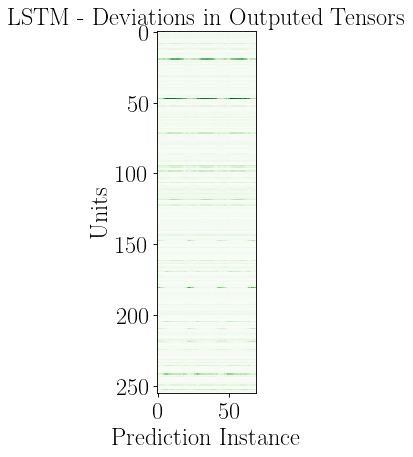

In [14]:
#Maybe we can see something with the LSTM layer units, could be interesting

def see_layers(model,
               visualize=True,
               save_fig=False):
    """
                                                    Description:
    --------------------------------------------------------------------------------------------------------------
    The function will allow to prepare the data for visualization that shows how the tensors transform and whether
    they show any signs of variation.
    --------------------------------------------------------------------------------------------------------------

                                                  Input Paramters:
    --------------------------------------------------------------------------------------------------------------
    > model     = model of a neural network being tested;
    > visualize = indicator whether the variation visualization should be outputed;
    > save_fig  = indicator whether the variation visualization should be saved;
    --------------------------------------------------------------------------------------------------------------

                                                       Output:
    --------------------------------------------------------------------------------------------------------------
    None
    --------------------------------------------------------------------------------------------------------------
    """

    # MAKE NEEDED IMPORTS
    import torch
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    output = model.retrieve_signal()  # Call a method from class to get all signals
    df = pd.DataFrame(output).transpose()

    if visualize == True:
        f = plt.figure(figsize=(8, 6), dpi=80)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        #Adjustments to the font
        MEDIUM_SIZE = 22
        plt.rc('font', size = MEDIUM_SIZE)      
        plt.rc('axes', titlesize = MEDIUM_SIZE)     
        plt.rc('axes', labelsize = MEDIUM_SIZE)    
        plt.rc('xtick', labelsize = MEDIUM_SIZE)    
        plt.rc('ytick', labelsize = MEDIUM_SIZE)    
        plt.rc('legend', fontsize = MEDIUM_SIZE)    
        plt.rc('figure', titlesize = MEDIUM_SIZE)
        
        plt.title("LSTM - Deviations in Outputed Tensors", fontsize=MEDIUM_SIZE)
        plt.xlabel("Prediction Instance", fontsize=MEDIUM_SIZE)
        plt.ylabel("Units", fontsize=MEDIUM_SIZE)
        plt.imshow(df, cmap=plt.get_cmap('Greens'))
        plt.show()

    if save_fig == True:
        f = plt.figure(figsize=(8, 6), dpi=80)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        #Adjustments to the font
        MEDIUM_SIZE = 25
        plt.rc('font', size = MEDIUM_SIZE)      
        plt.rc('axes', titlesize = MEDIUM_SIZE)     
        plt.rc('axes', labelsize = MEDIUM_SIZE)    
        plt.rc('xtick', labelsize = MEDIUM_SIZE)    
        plt.rc('ytick', labelsize = MEDIUM_SIZE)    
        plt.rc('legend', fontsize = MEDIUM_SIZE)    
        plt.rc('figure', titlesize = MEDIUM_SIZE)
        
        plt.title("LSTM - Deviations in Outputed Tensors", fontsize=MEDIUM_SIZE)
        plt.xlabel("Prediction Instance", fontsize=MEDIUM_SIZE)
        plt.ylabel("Units", fontsize=MEDIUM_SIZE)
        plt.imshow(df, cmap=plt.get_cmap('Greens'))
        layers_plt = model.lstm.num_layers  # How many layers were used here
        neurons_plt = model.lstm.hidden_size  # How many neurons were used here
        fname = str("Variations in LSTM _ model uses {} layer(s), {} neuron(s).pdf".format(layers_plt, neurons_plt))
        f.savefig(fname, bbox_inches='tight')
        plt.close(f)
        
see_layers(model,
           visualize = True,
           save_fig = True)

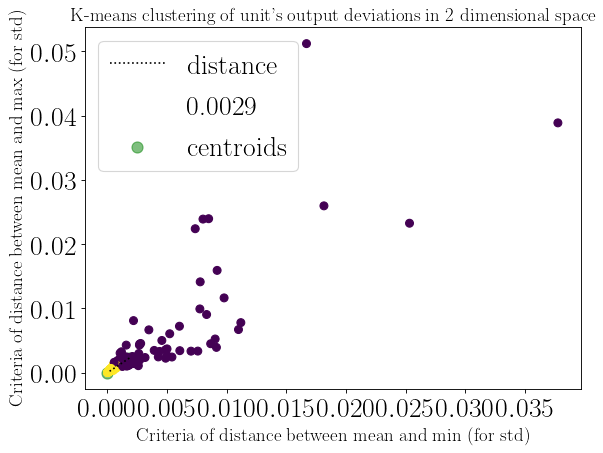

----------------------LOG--------------------------

> 117 neurons in class 0 
> 139 neurons in class 1.

Nueron#		Class		    Coordinates
   1 		  0 		[X: 0.003, Y: 0.001].
   2 		  1 		[X: 0.0, Y: 0.0].
   3 		  0 		[X: 0.002, Y: 0.001].
   4 		  0 		[X: 0.001, Y: 0.002].
   5 		  0 		[X: 0.002, Y: 0.002].
   6 		  0 		[X: 0.001, Y: 0.001].
   7 		  1 		[X: 0.0, Y: 0.0].
   8 		  0 		[X: 0.001, Y: 0.001].
   9 		  1 		[X: 0.0, Y: 0.0].
   10 		  0 		[X: 0.009, Y: 0.005].
   11 		  0 		[X: 0.001, Y: 0.001].
   12 		  1 		[X: 0.0, Y: 0.001].
   13 		  1 		[X: 0.001, Y: 0.001].
   14 		  0 		[X: 0.004, Y: 0.002].
   15 		  1 		[X: 0.0, Y: 0.0].
   16 		  1 		[X: 0.0, Y: 0.001].
   17 		  0 		[X: 0.003, Y: 0.002].
   18 		  1 		[X: 0.0, Y: 0.0].
   19 		  1 		[X: 0.0, Y: 0.0].
   20 		  1 		[X: 0.0, Y: 0.0].
   21 		  0 		[X: 0.025, Y: 0.023].
   22 		  1 		[X: 0.0, Y: 0.0].
   23 		  0 		[X: 0.002, Y: 0.002].
   24 		  1 		[X: 0.0, Y: 0.0].
   25 		  0 		[X: 0.002, Y: 0.001].
   26 		  1

117

In [15]:
#See what's going on with the k-means clustering approach
def nn_analysis(model,
                visualize=False,
                save_fig=False,
                prep_log=False,
                log_save=False,
                kpi=True):
    """
    Description:
    -----------------------------------------------------------------------------------------------------------
    The function will perform an analysis of the network based on the variations in the patterns of outputs that
    happen in the LSTM layer. The full analysis is done with the method of k-means analysis approach. Neurons that
    show insignificant (small to none) variation become suggested for pruning.
    -----------------------------------------------------------------------------------------------------------

    Input Parameters:
    -----------------------------------------------------------------------------------------------------------
    > model     = model from which the information will be retrieved for evaluation;
    > visualize = indicate whether the clustering plot should be visualized or not, DEFAULT: False;
    > save_fig  = indicate whether the clustering plot should be saved or not. DEFAULT: False;
    > prep_log  = indicate whether you want a full log of which neurons to prune and which ones are in which cluster
                 with their coordinates. Recommended for general overview, DEFAULT: False;
    > log_save  = will save a short log of how many neurons in which classes there are. Default: False;
    > kpi       = indicate whether an output value should be present that says how many neurons to retain for re-training.
                  DEFAULT: True;
    -----------------------------------------------------------------------------------------------------------

    Output:
    -----------------------------------------------------------------------------------------------------------
    > retain = indicates how many neurons should remain in the network if re-training happens under same conditions
    -----------------------------------------------------------------------------------------------------------
    """

    # Import packages
    import torch
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    output = model.retrieve_signal()  # Call a method from class to get all signals
    df = pd.DataFrame(output).transpose()
    data_collector = np.array(df)

    # We want to find those neurons that actually deviate
    # We could try searching for them with Standard Deviations; or Find Min, Max in the sequence, and the Mean
    # Calculating the difference between mean -> max & min, will give us a 2x matrix, which we can use to calculate
    # the clusters. It's not too big of a dimensional space, but more than of a single value. Though both might be
    # experimented with.
    analysis_data = []
    for row in data_collector:
        mean_temp = row.mean()
        max_temp = row.max()
        min_temp = row.min()

        # Convert indicators above into indicators
        idx_1 = mean_temp - min_temp
        idx_2 = max_temp - mean_temp
        temp_holder = [idx_1, idx_2]

        analysis_data.append(temp_holder)

    analysis_data = np.array(analysis_data)

    # import packages for clustering and for euclidean distance calculation
    from sklearn.cluster import KMeans
    from sklearn.metrics.pairwise import euclidean_distances

    # We will enforce one centroid to be 0.0. Benefit = the class will be stably the same
    # The second centroid will be - the centroid of all the data points.
    # Whatever falls not in the data points centroid but of the 0.0, 0.0 location will be suggested for pruning

    kmeans = KMeans(n_clusters=2, random_state=0, n_init=50).fit(analysis_data)  # Clustering method will be used
    kmeans_dummy = KMeans(n_clusters=1, random_state=0, n_init=50).fit(analysis_data)  # Create a all data cluster
    new_centroids = np.append(kmeans_dummy.cluster_centers_[0].reshape(-1, 2), [[0.0, 0.0]], axis=0)  # enforce needed values
    kmeans.cluster_centers_ = new_centroids

    y_kmeans = kmeans.predict(analysis_data)
    x, y = zip(*new_centroids)

    # Prepare information for the plot
    f = plt.figure(figsize=(8, 6), dpi=80)

    # Will show the centroids distance
    plt.plot(x, y, "k:", label="distance")
    plt.plot([], [], ' ', label="{}".format(np.round(euclidean_distances(new_centroids)[0][1], 4)))
    plt.scatter(new_centroids[:, 0], new_centroids[:, 1], c='green', s=100, alpha=0.5, label="centroids")

    # Will show data points
    x, y = zip(*analysis_data)
    plt.scatter(x, y, c=y_kmeans, s=50)

    plt.legend(loc="best")
    MEDIUM_SIZE = 17
    plt.rc('xtick', labelsize = 15)    
    plt.rc('ytick', labelsize = 15)
    plt.title("K-means clustering of unit's output deviations in 2 dimensional space", fontsize=MEDIUM_SIZE)
    plt.xlabel("Criteria of distance between mean and min (for std)", fontsize=MEDIUM_SIZE)
    plt.ylabel("Criteria of distance between mean and max (for std)", fontsize=MEDIUM_SIZE)
    if visualize == True:
        plt.show()
    elif visualize == False:
        plt.close()

    if save_fig == True:
        layers_plt = model.lstm.num_layers
        neurons_plt = model.lstm.hidden_size
        fname = str(
            "K-means clustering of units using {} layer(s) and {} unit(s).pdf".format(layers_plt, neurons_plt))
        f.savefig(fname, bbox_inches='tight')

    # Make a calculations for the log of the observations and the output
    # First we check how many and which observations are of which cluster
    log = str()
    log_calculator_1 = len(y_kmeans)
    for i, value in enumerate(y_kmeans):
        if value == 0:
            log_calculator_1 -= 1
        i += 1
        log += str(
            "   {} \t\t  {} \t\t[X: {}, Y: {}].\n".format(i, value, np.round(x[i - 1], 3), np.round(y[i - 1], 3)))
    log_calculator_0 = len(y_kmeans) - log_calculator_1

    if prep_log == True:
        print("----------------------LOG--------------------------\n")
        print("> {} neurons in class 0 \n> {} neurons in class 1.".format(log_calculator_0, log_calculator_1))
        print()
        print("Nueron#\t\tClass\t\t    Coordinates")
        print(log)
        print("---------------------------------------------------")

    if log_save == True:
        outF = open("Full Data Log _ Thesis.txt", "a+")
        outF.write("\n __Clusters Log__\n")
        outF.write("> {} neurons in class 0 \n> {} neurons in class 1.".format(log_calculator_0, log_calculator_1))
        outF.close()

    retain = log_calculator_0
    if kpi == True:
        return retain
    
nn_analysis(model = model,
            visualize = True,
            save_fig = True,
            prep_log = True,
            log_save = True,
            kpi = True)

In [16]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)

#At this moment let's save the models and weights to the fc layer
#This will not change the composition so we need only one variable
pruned_model = model 
#Save prunned model as is
torch.save(pruned_model.state_dict(), "Pruned_Model_Sin_SOTA.pt")

In [17]:
import numpy as np
from scipy.sparse import csc_matrix
#Save prunned model's weight values (connections) that lay between the lstm and fc layers
#If there is any sparsity, we account for it before saving
#Sparse format will be re-used when saving the models for the SOTA baseline

#We need a zeros matrix that is equal in shape to our weights matrix
zeros_M = np.zeros(len(pruned_model.fc.weight.data.flatten())).reshape(np.array(pruned_model.fc.weight.data.cpu().numpy()).shape[0], 
                                                                        np.array(pruned_model.fc.weight.data.cpu().numpy()).shape[1])

pruned_model_WM = pruned_model.fc.weight.data.cpu().numpy() #WM - weight matrix
pruned_model_WM[np.isclose(pruned_model.fc.weight.data.cpu().numpy(),zeros_M)] = 0
pruned_model_WM = csc_matrix(pruned_model_WM)
np.save(file = "Pruned_Sparse_Weights_SOTA.npy", arr = pruned_model_WM)

In [18]:
#Now to compare the final sizes (information is in bytes)
#Pruning here is a tad bit different
import os

#For models saved as is
pruned_full  = os.path.getsize("Pruned_Model_Sin_SOTA.pt")
#For models saved with lstm-fc weights
pruned_weights  = os.path.getsize("Pruned_Sparse_Weights_SOTA.npy")

#Sizes:
print("Size of the Pruned/Original model is: \t\t\t{} bytes".format(pruned_full))
print("Size of the Pruned/Original model in a sparse matrix: \t{} bytes".format(pruned_weights))

Size of the Pruned/Original model is: 			2942113 bytes
Size of the Pruned/Original model in a sparse matrix: 	45191 bytes


In [19]:
os.chdir('../Method')
pruned_sparse_exp_size    = os.path.getsize("Pruned_Sparse_Weights.npy")
pruned_sparse_exp_weights = np.load("Pruned_Sparse_Weights.npy", allow_pickle = True)
pruned_exp                = os.path.getsize("Pruned_Model_Sin.pt")

print("Size of the weights in a sparse matrix prunned with the proposed method: \t{} bytes".format(pruned_sparse_exp_size))
print("Size of the weights in a sparse matrix prunned with the SOTA method: \t\t{} bytes".format(pruned_weights))
print("The above difference is of: {} times".format(np.round(pruned_weights/pruned_sparse_exp_size, 2)))

print()
print("Actual size of the experimented model is: \t{}  bytes".format(pruned_exp))
print("Actual size of the SOTA model is: \t\t{} bytes".format(pruned_full))

print()
print("However! We do need to account for small discrepancy in how many weights remain within both models!")
print("The experimented model holds: \t{}".format(csc_matrix.count_nonzero(csc_matrix(pruned_sparse_exp_weights.tolist().toarray()))))
print("The SOTA model holds: \t\t{}".format(csc_matrix.count_nonzero(pruned_model_WM)))
print("The difference is that the SOTA has more weights by {} times".format(csc_matrix.count_nonzero(pruned_model_WM) / csc_matrix.count_nonzero(csc_matrix(pruned_sparse_exp_weights.tolist().toarray()))))

print()
print("For this case, there is an emphasis that: the problem stays that because the units are not pruned in SOTA, the model if saved\
 still is quite big. The second issue about weights - saved weights for the experimented model take smaller storage space\
 by almost x3 times, where they themselves only hold x1.5 less weights in lstm-fc connections. This still makes them x2 times\
 more compact, but this might change if we change the size of the model in SOTA. The performance of both models are almost the sames, \
 with SOTA being just a tiny bit better. What can be taken from all of this, is that the automated methodology at least works as\
 well as SOTA, meaning it holds weight in being exploited (depending also on how it shows itself on other tasks).")

Size of the weights in a sparse matrix prunned with the proposed method: 	13972 bytes
Size of the weights in a sparse matrix prunned with the SOTA method: 		45191 bytes
The above difference is of: 3.23 times

Actual size of the experimented model is: 	7876  bytes
Actual size of the SOTA model is: 		2942113 bytes

However! We do need to account for small discrepancy in how many weights remain within both models!
The experimented model holds: 	800
The SOTA model holds: 		1208
The difference is that the SOTA has more weights by 1.51 times

For this case, there is an emphasis that: the problem stays that because the units are not pruned in SOTA, the model if saved still is quite big. The second issue about weights - saved weights for the experimented model take smaller storage space by almost x3 times, where they themselves only hold x1.5 less weights in lstm-fc connections. This still makes them x2 times more compact, but this might change if we change the size of the model in SOTA. The p

In [20]:
import os
os.chdir('../Baseline SOTA')
os.getcwd()

'C:\\Users\\20194309\\Thesis\\CURRENT WORKING ON\\Fully Arranged Code\\Experiments_DiffGraphs\\Sin Wave\\Baseline SOTA'

In [21]:
#Note: this process is done post hoc. Therefore some values like number of units or inputs and outputs are hardcoded.

import numpy as np
from scipy.sparse import csc_matrix
prun_w = np.load(file = "Pruned_Sparse_Weights_SOTA.npy",  allow_pickle = True)
unprun_w = csc_matrix(prun_w.all()).toarray()
print("Verify the shape. There are {} outputs and {} input connections from each unit".format((unprun_w).shape[0], (unprun_w).shape[1]))
print("The model has initially 256 Units")
print("This means each unit has {} output connections".format((unprun_w).shape[1]/256))
print("With there being initially 20 inputs, this fully makes sense.")
print("Because weights are recorded sequentially - it is possible to figure out which units had to be pruned.")

Verify the shape. There are 20 outputs and 5120 input connections from each unit
The model has initially 256 Units
This means each unit has 20.0 output connections
With there being initially 20 inputs, this fully makes sense.
Because weights are recorded sequentially - it is possible to figure out which units had to be pruned.


In [22]:
#We can create a dictionary to see how many units have to be pruned and how many - not
#Their exact value is not valuable here
P_NP = {}
#We can populate the dictionary right away saying that all units need to be retained
P_NP['Do not prune'] = 256
P_NP['Prune'] = 0

#Enter each units output weights
for i, id_unit in enumerate(unprun_w):
    #Check each connection from the output connections
    #If even one is larger than 0, then the unit will be consider as retainable
    #We can also check for things like np.max to speed up the process, but that's for code optimization in the future
    #As we are working with quite a small dataset here
    for id_connection in id_unit:
        if id_connection == 0.0:
            continue
        else:
            P_NP["Prune"] += 1.0
            P_NP['Do not prune'] -= 1.0
            break
            
print(P_NP)    
print("Final verdict: we need to prune fully {} units and retain {}".format(P_NP["Prune"], P_NP['Do not prune']))

{'Do not prune': 236.0, 'Prune': 20.0}
Final verdict: we need to prune fully 20.0 units and retain 236.0
